In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, gs

In [2]:
band = 'F184'
grid_oversample = 3
num_pix = 45
side = 4.95
ra = 30
dec = -30
wcs = gs.get_wcs(ra, dec)
exposure_time = 146
bands = ['F106', 'F129', 'F184']  # TODO choose one band
detector = 1

In [3]:
# calculate sky backgrounds for each band
bkgs = gs.get_sky_bkgs(wcs, bands, detector, exposure_time, num_pix=num_pix)

In [4]:
# draw interpolated image at the final pixel scale
im = galsim.ImageF(num_pix, num_pix, scale=0.11)  # NB setting dimensions to "input_size" because we'll crop down to "output_size" at the very end
im.setOrigin(0, 0)

In [5]:
# add sky background to convolved image
final_image = im + bkgs[band]

# integer number of photons are being detected, so quantize
final_image.quantize()

# add all detector effects
# create galsim rng
rng = galsim.UniformDeviate(seed=42)
galsim.roman.allDetectorEffects(final_image, prev_exposures=(), rng=rng, exptime=exposure_time)

# make sure there are no negative values from Poisson noise generator
final_image.replaceNegative()

# get the array
final_array = final_image.array

# center crop to get rid of edge effects
# final_array = util.center_crop_image(final_array, (output_size, output_size))

# divide through by exposure time to get in units of counts/sec/pixel
final_array /= exposure_time

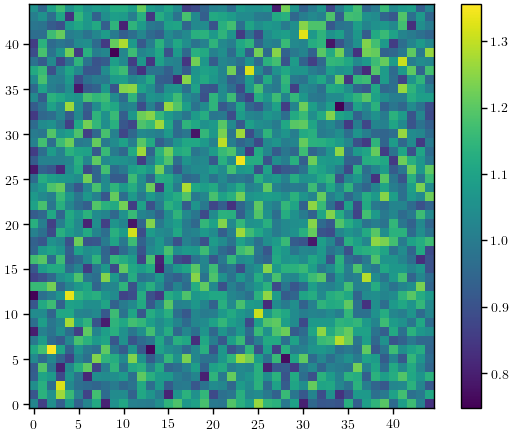

In [7]:
plt.imshow(final_array)
plt.colorbar()
plt.show()

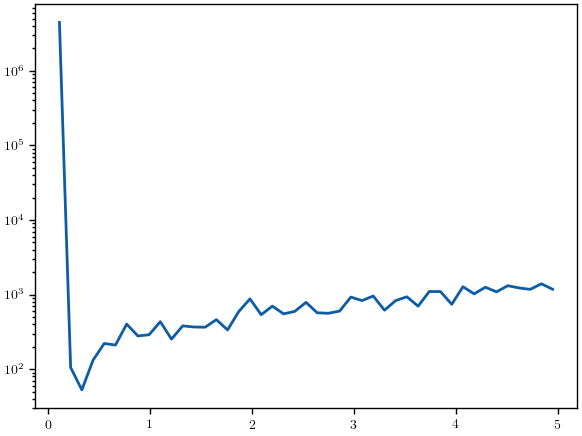

In [9]:
from mejiro.analysis import ft

theta_list = ft.get_theta_list(0.11, 4.95, final_array.shape[0])
power_spectrum = ft.power_spectrum(final_array)

plt.plot(theta_list, power_spectrum)
plt.yscale('log')
plt.show()

as expected, shot noise (Poisson) dominates at smallest scale